# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [1]:
# Imports

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats
import sklearn.preprocessing as pre
from datetime import datetime

## Part 1 - Importing Datasets

### Part (a) - Parsing Data into Pandas

In [2]:
# Prepare for import
raw_datasets = {}
dataset_paths = glob.glob('imu_data/*.csv')
N_DATASETS = len(dataset_paths)

dataset_paths

['imu_data/PhoneLeftConcrete.csv',
 'imu_data/PhoneLeftCarpet.csv',
 'imu_data/WheelRightGravel.csv',
 'imu_data/PhoneLeftSidewalk.csv',
 'imu_data/WheelLeftConcrete.csv',
 'imu_data/PhoneMiddleSidewalk.csv',
 'imu_data/WheelLeftCarpet.csv',
 'imu_data/WheelRightCarpet.csv',
 'imu_data/PhoneRightAsphalt2.csv',
 'imu_data/WheelLeftGravel.csv',
 'imu_data/PhoneMiddleConcrete.csv',
 'imu_data/WheelLeftLinoleum.csv',
 'imu_data/PhoneRightGrass.csv',
 'imu_data/PhoneMiddleGrass.csv',
 'imu_data/WheelRightConcrete.csv',
 'imu_data/PhoneRightGravel.csv',
 'imu_data/PhoneMiddleCarpet.csv',
 'imu_data/PhoneRightSidewalk.csv',
 'imu_data/WheelRightGrass.csv',
 'imu_data/PhoneRightCarpet.csv',
 'imu_data/FrameMiddleGravel.csv',
 'imu_data/WheelRightLinoleum.csv',
 'imu_data/FrameMiddleGrass.csv',
 'imu_data/PhoneMiddleLinoleum.csv',
 'imu_data/WheelRightAsphalt2.csv',
 'imu_data/WheelLeftGrass.csv',
 'imu_data/FrameMiddleCarpet.csv',
 'imu_data/FrameMiddleLinoleum.csv',
 'imu_data/WheelLeftAsphal

In [36]:
frame_columns = ['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 
                 'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)',
                 'YYYY-MO-DD HH-MI-SS_SSS' ]

wheel_columns = ['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 
                 'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)',
                 'Time received in s', 'YYYY-MO-DD HH-MI-SS_SSS']

phone_columns = ['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 
                 'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)',
                 'Time since start in ms ', 'YYYY-MO-DD HH-MI-SS_SSS']

data_columns = ['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 
                 'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)']

renamed_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Time']

def get_columns(_label):
    columns = []
    if 'Phone' in _label:
        columns = phone_columns.copy()
    elif 'Frame' in _label:
        columns = frame_columns.copy()
    elif 'Wheel' in _label:
        # TODO: Fix this once this is more standardized
        if 'Concrete' in _label or 'Carpet' in _label or 'Linoleum' in _label:
            columns = wheel_columns.copy()
        else:
            columns = phone_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # Transformed datasets have an extra column
    if ('FFT' in _label or 'PSD' in _label):
        columns.remove('YYYY-MO-DD HH-MI-SS_SSS')
        if 'Wheel' in _label:
            if ('Carpet' in _label or 'Linoleum' in _label or 'Concrete' in _label):
                columns.remove('Time received in s')
            else:
                columns.remove('Time since start in ms ')
        elif 'Phone' in _label:
            columns.remove('Time since start in ms ')
        columns.append('Frequency (Hz)')
    return columns

In [4]:
# Import datasets as an array of Pandas DataFrames
TRIM_LEN = 2000 # Number of data points to trim from each side
N_DATA_COL = 6 # Number of columns containing directional data

remove_columns = ['LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
                  'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)', 'GRAVITY Z (m/s²)', 
                  'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)',
                  'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'ORIENTATION Z (azimuth °)']
dataset_labels = []

for dataset_path in dataset_paths:
    # Parse labels
    dataset_name = dataset_path.split(' ')[-1].split('/')[-1].split('.')[0]
    dataset_labels.append(dataset_name)
    
    # Read from CSV
    dataset = pd.read_csv(dataset_path)
        
    # Drop unused columns
    for to_remove in remove_columns:
        if to_remove in dataset.columns:
            dataset = dataset.drop(to_remove, axis=1)
            #print('Removed ' + to_remove)
            
    # Convert string format to epoch time
    if any(s in dataset_name for s in ('Phone', 'Asphalt', 'Grass', 'Gravel', 'Sidewalk')):
        dataset['YYYY-MO-DD HH-MI-SS_SSS'] = dataset['YYYY-MO-DD HH-MI-SS_SSS'].apply(datetime.strptime, 
                                                                                      args=("%Y-%m-%d %H:%M:%S:%f",))
        dataset['YYYY-MO-DD HH-MI-SS_SSS'] = dataset['YYYY-MO-DD HH-MI-SS_SSS'].apply(datetime.timestamp)
    
    # Trim edges to account for startup time
    #dataset = dataset[TRIM_LEN:-TRIM_LEN]
    
    raw_datasets.update({dataset_name: dataset})

In [5]:
# Standardize order of columns
for label in raw_datasets.keys():
    raw_datasets[label] = raw_datasets[label][get_columns(label)]

In [6]:
# Check dataset validity
raw_datasets['FrameMiddleCarpet'].head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),YYYY-MO-DD HH-MI-SS_SSS
0,-0.480044,-2.051458,-9.479465,0.119472,-0.059936,0.060868,1.559244e+09
1,0.573187,-2.526725,-10.752418,0.013585,0.065397,0.119072,1.559244e+09
2,-1.511780,-2.342828,-9.534395,-0.008791,0.018913,0.095364,1.559244e+09
3,-0.074037,-1.287209,-9.586938,0.028769,-0.056073,0.105753,1.559244e+09
4,0.439443,-1.805465,-10.301033,0.104155,0.060469,0.136787,1.559244e+09


In [7]:
# Check dataset validity
raw_datasets['FrameMiddleGrass'].head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),YYYY-MO-DD HH-MI-SS_SSS
0,0.444220,-1.523648,-9.269297,0.042621,0.034630,0.252396,1.559605e+09
1,0.620952,-2.072952,-9.608432,0.120937,0.039957,0.202716,1.559605e+09
2,0.900381,-2.424029,-10.910044,0.016382,0.059669,0.285960,1.559605e+09
3,0.212557,-1.834125,-9.434088,0.015716,0.037826,0.245737,1.559605e+09
4,0.814403,-1.303927,-9.092564,0.081113,0.059270,0.280633,1.559605e+09


In [8]:
# Check dataset validity
raw_datasets['WheelLeftCarpet'].head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),Time received in s,YYYY-MO-DD HH-MI-SS_SSS
0,-8.213183,6.481005,-0.322015,0.042501,-0.027977,-0.014793,1.559244e+09,1.559244e+09
1,-8.195227,6.486990,-0.332789,0.042234,-0.027178,-0.014660,1.559244e+09,1.559244e+09
2,-8.216774,6.500158,-0.311241,0.043033,-0.028376,-0.013595,1.559244e+09,1.559244e+09
3,-8.217971,6.501355,-0.310044,0.043166,-0.027577,-0.013728,1.559244e+09,1.559244e+09
4,-8.232336,6.473822,-0.330395,0.042501,-0.028642,-0.015459,1.559244e+09,1.559244e+09


In [9]:
raw_datasets['WheelLeftAsphalt'].head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),Time since start in ms,YYYY-MO-DD HH-MI-SS_SSS
0,0.061051,9.863960,-0.422570,0.038904,0.016111,-0.108428,0.000000,1.559590e+09
1,0.087387,9.856777,-0.423767,0.038505,0.016910,-0.108561,0.004992,1.559590e+09
2,0.058657,9.829245,-0.359125,0.038638,0.018242,-0.109493,0.010016,1.559590e+09
3,0.086190,9.831639,-0.381869,0.038904,0.019706,-0.108029,0.015008,1.559590e+09
4,0.095767,9.836427,-0.385461,0.039837,0.017975,-0.108694,0.020000,1.559590e+09


It looks like the update rate of the IMU is non deterministic and lower than the rate the phone samples it at, i.e. the phone receives a non-deterministic number of sequential identical measurements from the IMU when polling at approx 200 Hz.

### Part (b) - Visualizing Time Domain Data

In [10]:
'''Compare phones mounted in different locations'''
def phone_compare(dirn, surface):
    plt.clf()
    fig = plt.figure(figsize=(30, 10))
    
    plt.plot(raw_datasets['PhoneLeft' + surface]['YYYY-MO-DD HH-MI-SS_SSS'],
             raw_datasets['PhoneLeft' + surface][dirn], label='Left')
    plt.plot(raw_datasets['PhoneRight' + surface]['YYYY-MO-DD HH-MI-SS_SSS'],
             raw_datasets['PhoneRight' + surface][dirn], label='Right')
    plt.plot(raw_datasets['PhoneMiddle' + surface]['YYYY-MO-DD HH-MI-SS_SSS'],
             raw_datasets['PhoneMiddle' + surface][dirn], label='Middle')
    
    plt.xlabel('Epoch Time (s)')
    plt.ylabel(dirn + ' on ' + surface)
    plt.legend()
    plt.show()

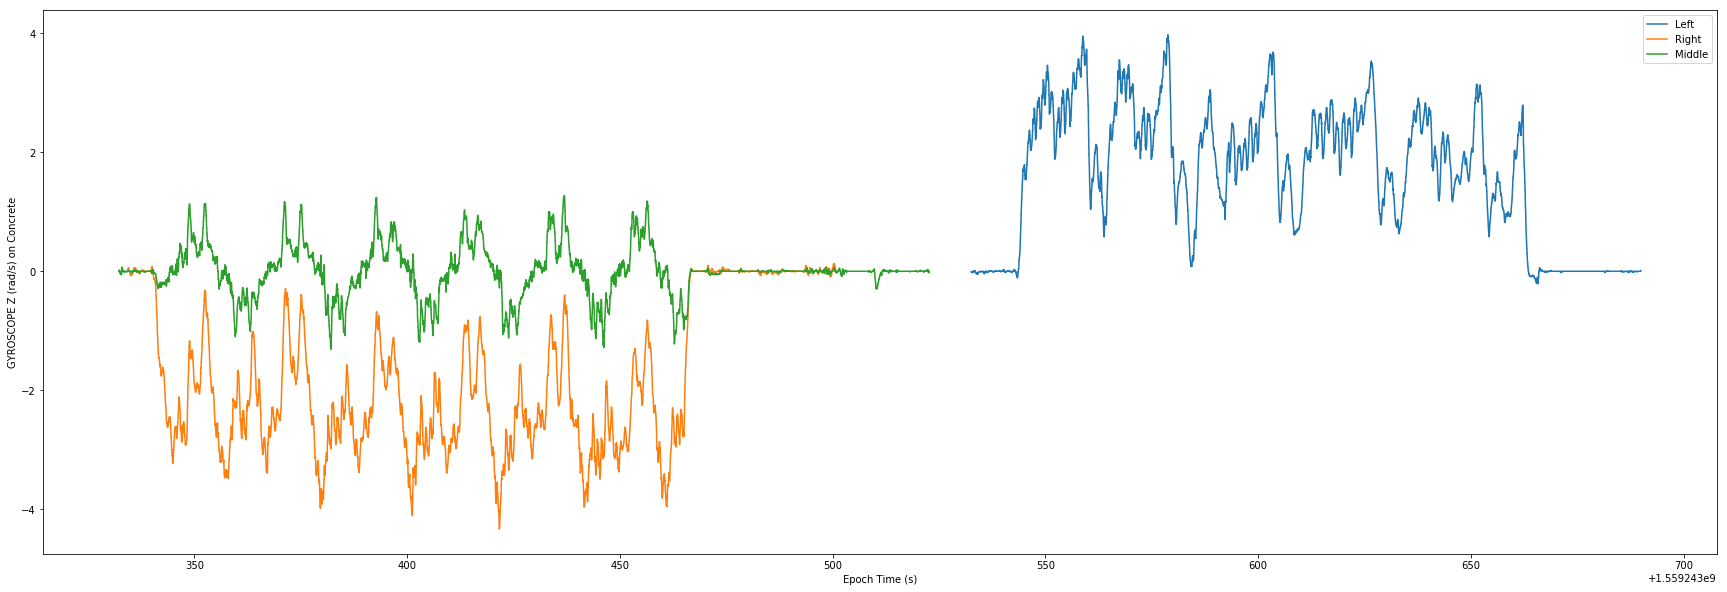

In [11]:
phone_compare('GYROSCOPE Z (rad/s)', 'Concrete')

In [12]:
'''Compare different labels'''
def label_compare(label1, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(30,10))
    
    # Plot with offsets
    ax.plot(raw_datasets[label1]['YYYY-MO-DD HH-MI-SS_SSS'].apply(lambda x: x + t_offset), 
             raw_datasets[label1][dirn].apply(lambda x: x + y_offset), label=label1)
    ax.plot(raw_datasets[label2]['YYYY-MO-DD HH-MI-SS_SSS'], raw_datasets[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel(dirn)
    ax.set_title(dirn + ' on ' + label1 + ' and ' + label2)
    offset_text = 'Offsets\n'
    offset_text += label1 + ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    ax.legend()
    plt.show()

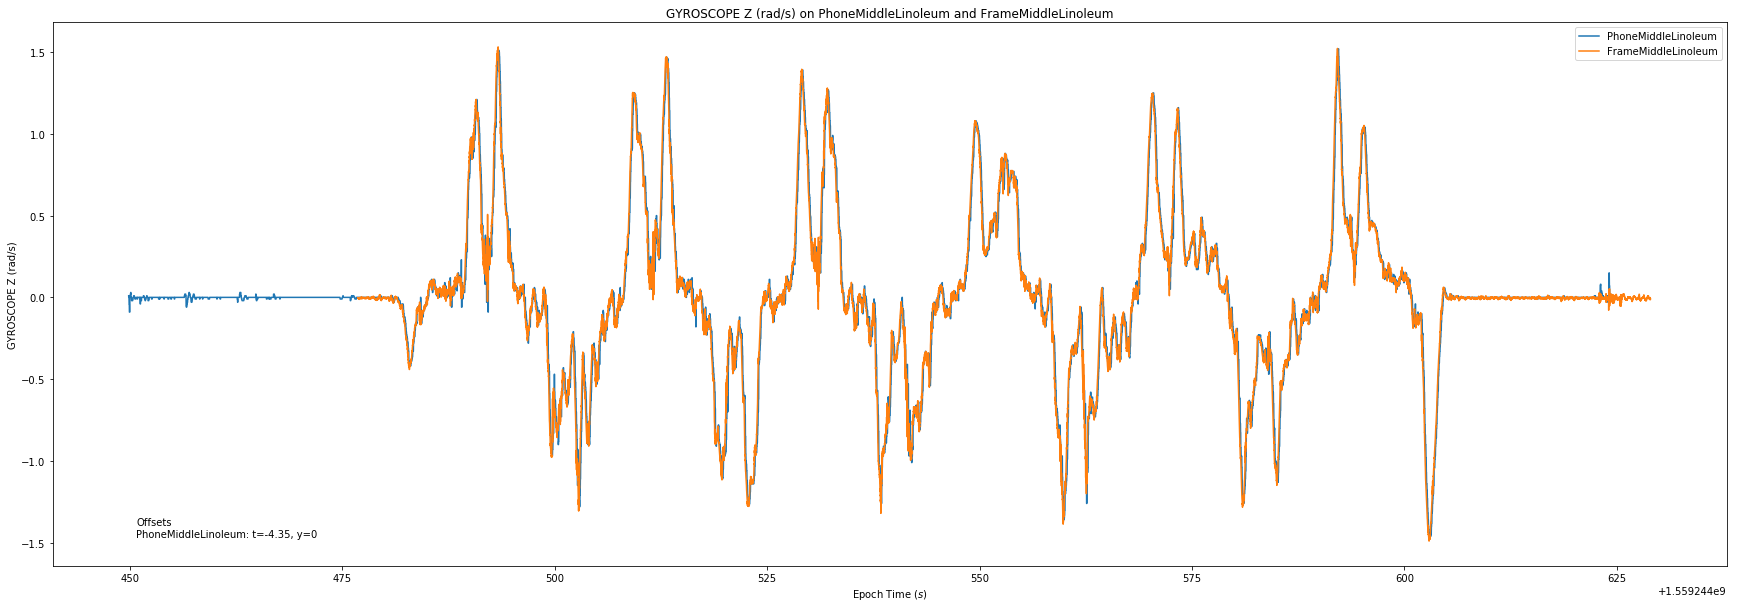

In [13]:
# Corrected
label_compare('PhoneMiddleLinoleum', 'FrameMiddleLinoleum', 'GYROSCOPE Z (rad/s)', t_offset=-4.35)

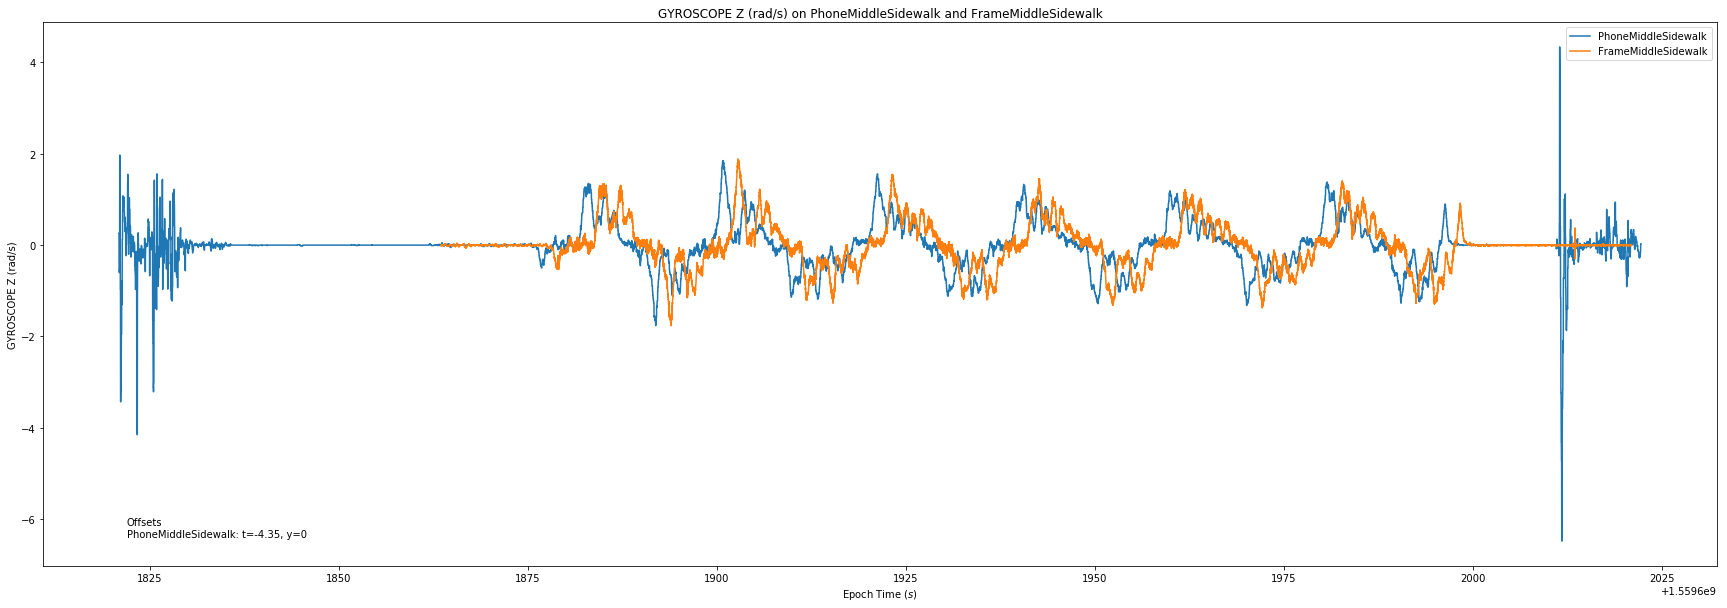

In [14]:
# Corrected
label_compare('PhoneMiddleSidewalk', 'FrameMiddleSidewalk', 'GYROSCOPE Z (rad/s)', t_offset=-4.35)

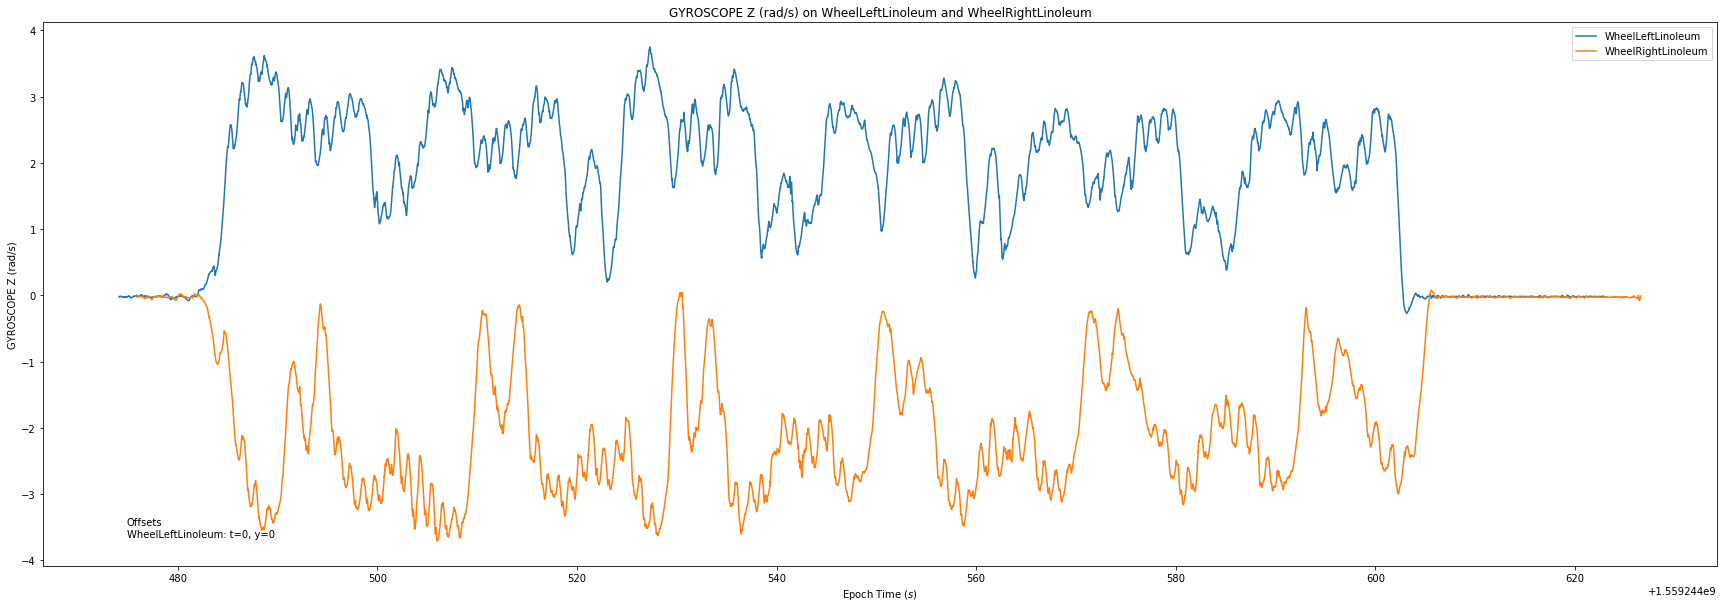

In [15]:
# Uncorrected
label_compare('WheelLeftLinoleum', 'WheelRightLinoleum', 'GYROSCOPE Z (rad/s)')

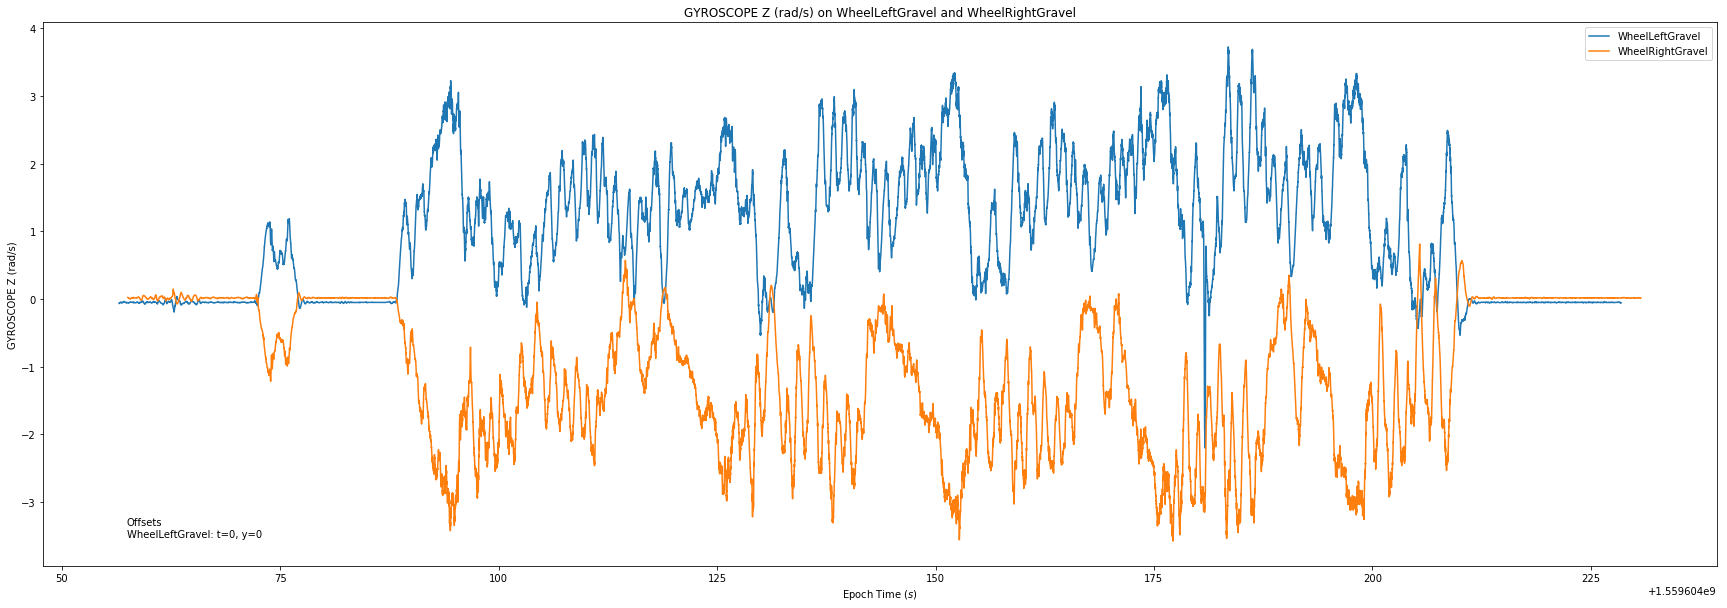

In [16]:
label_compare('WheelLeftGravel', 'WheelRightGravel', 'GYROSCOPE Z (rad/s)')

In [17]:
'''Plot given x annd y axes for every dataset in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, x_unit='($s$)', y_unit='($m/s^2$)'):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        axes[i].plot(dataset[x_axis], dataset[y_axis])
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' ' + x_unit)
        axes[i].set_ylabel(y_axis + ' ' + y_unit)
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

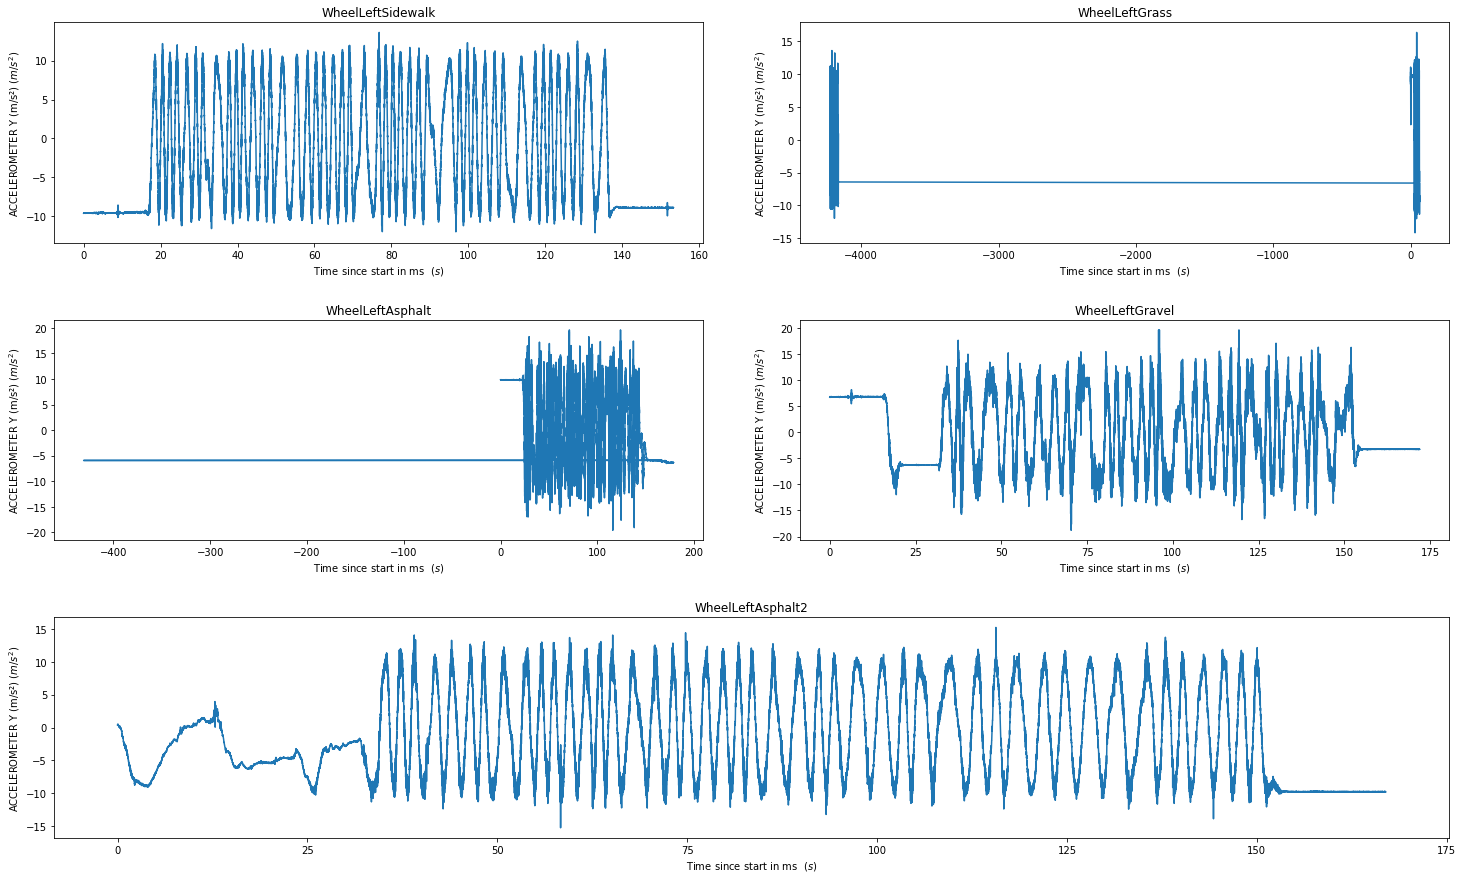

In [18]:
# Plot some examples
datasets_to_plot = {}

# Only frame data
for label, dataset in raw_datasets.items():
    if ('WheelLeft' in label):
        if ('Asphalt' in label or 'Grass' in label or 'Gravel' in label or 'Sidewalk' in label):
            datasets_to_plot.update({label: dataset})
        
plot_all(datasets_to_plot,
         x_axis='Time since start in ms ', 
         y_axis='ACCELEROMETER Y (m/s²)')

### Part (c) - Converting Between Pandas and Numpy

In [19]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.as_matrix()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [20]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
'''Need to add columns names later'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [21]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [22]:
# Check if its constructed correctly
print('Num datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Num datasets: 42
Shape of first dataset: (31481, 8)


## Part 2 - Filtering

Datasheets of smartphone level IMUs suggest that IMU filters data before sending it to the phone, and that the cutoff frequency of this filtering is configurable and changes with update frequency.

Based on the IMU update rate of about 20 ms, this cutoff frequency is already close to 40 Hz, so filtering is probably unnecessary. Its hard to be sure about actual values because this is configured by the phone manufacturer.

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

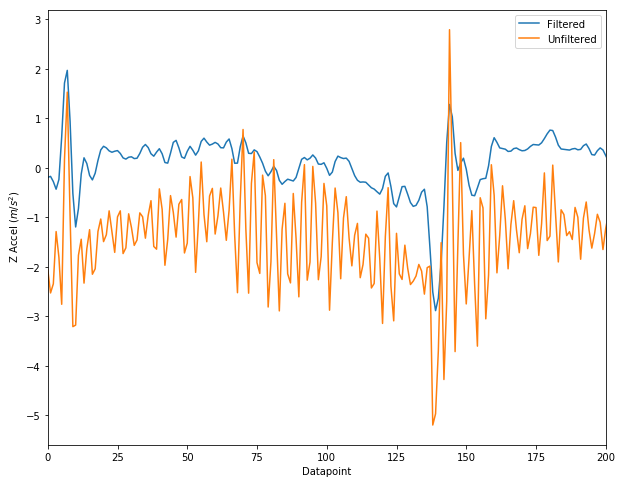

In [23]:
datasets = {} # Filtered data 

F_SAMP = 200 # Sampling frequency
F_CUT_HIGH = 40 # Cutoff frequency
F_CUT_LOW = 1

w_high = F_CUT_HIGH / (F_SAMP / 2) # Normalize the frequency
w_low = F_CUT_LOW / (F_SAMP / 2)
# Get Butterworth filter parameters
b_butter, a_butter = signal.butter(N=4, Wn=[w_low, w_high], btype='band')

# Filter each data column of every dataset
for label, dataset in raw_datasets.items(): # Make a copy first
    datasets.update({label: np.copy(dataset)})

for label, dataset in datasets.items():
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:,i])

# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 8))
plt.plot(datasets['FrameMiddleCarpet'][:, 1], label='Filtered')
plt.plot(raw_datasets['FrameMiddleCarpet'][:, 1], label='Unfiltered')
plt.xlim(0, 200)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel(' Z Accel ($m/s^2$)')
plt.show()

In [24]:
# Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 42
Shape of first filtered dataset: (31481, 8)


In [25]:
# Verify we can convert back to Pandas
# TODO: Fix this crashing when run multiple times
np_to_pd(datasets, windowed=False)[dataset_labels[2]].head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),Time since start in ms,YYYY-MO-DD HH-MI-SS_SSS
0,0.002910,0.014047,0.007219,-6.160943e-07,0.000083,0.001490,0.000000,1.559604e+09
1,-0.007010,0.023673,-0.009534,-1.929881e-04,-0.000177,0.001381,0.005120,1.559604e+09
2,-0.009726,0.024460,-0.017476,-4.542590e-04,-0.000350,0.001030,0.009984,1.559604e+09
3,-0.005315,0.018715,-0.013300,-7.882922e-04,-0.000359,0.000511,0.015104,1.559604e+09
4,-0.000280,0.014873,-0.000510,-1.093830e-03,-0.000210,0.000132,0.019968,1.559604e+09


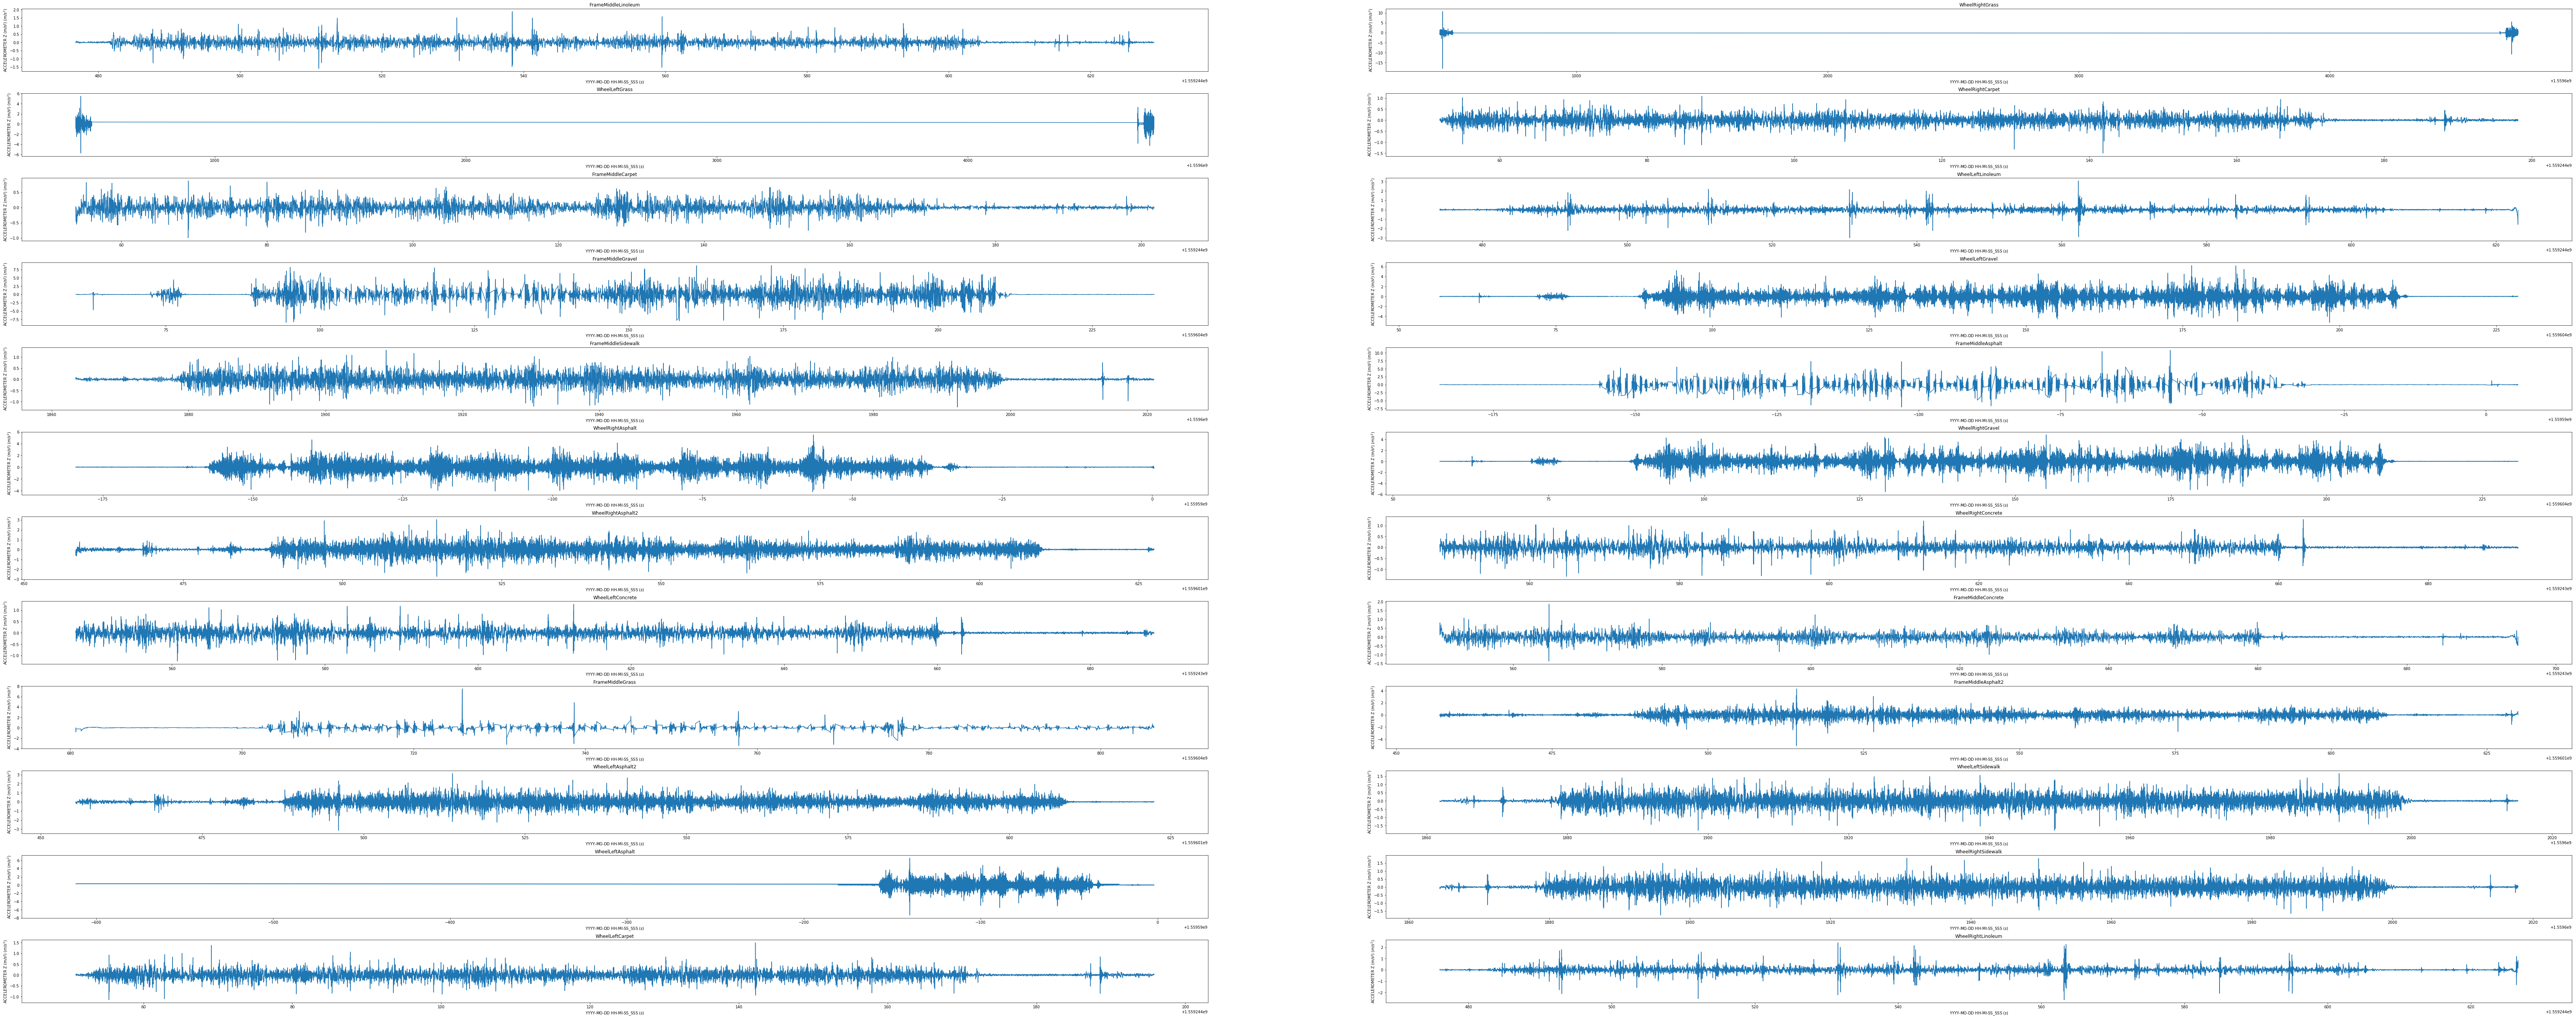

In [26]:
# Plot all filtered datasets
datasets_to_plot = {label: dataset for label, dataset in datasets.items() if ('Frame' in label or 'Wheel' in label)}
plot_all(np_to_pd(datasets_to_plot), x_axis='YYYY-MO-DD HH-MI-SS_SSS', y_axis='ACCELEROMETER Z (m/s²)')

## Part 3 - Time Windows

### Part (a) - Finding an optimal time window

Strategy is to start with a large time window and work down. 

Plot classification accuracy and time vs window size and find an optimal size

### Part (b) - Creating Time Windowed Data

In [29]:
# TODO: Create an array of different window sizes, taking out the desired array so don't have to rename things

WINDOW_SIZE = 100 # Divide by 200 to get sample size in seconds
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [30]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 42
Num of windows in first dataset: 314
Shape of individual window: (100, 8)


Structure of the data right now:

`1D Array containing each dataset -> 1D Array containg each window -> 2D NP Array of actual data for each sensor`

In [31]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)['FrameMiddleConcrete'][0].tail()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),YYYY-MO-DD HH-MI-SS_SSS
95,-0.205081,0.298915,-0.190766,0.012565,0.006393,-0.064699,1.559244e+09
96,-0.336862,0.112576,-0.131267,0.014926,-0.002681,-0.080714,1.559244e+09
97,-0.097790,-0.043064,-0.160608,0.009658,-0.011497,-0.089775,1.559244e+09
98,0.324329,-0.086404,-0.191443,-0.001282,-0.010680,-0.088540,1.559244e+09
99,0.589914,-0.002627,-0.149760,-0.008603,-0.001852,-0.079272,1.559244e+09


## Part 4 - FFT and PSD


In [32]:
'''Plot tranform of given direction and window'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(8, 6))

    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')
    
    plt.title(transform_name +' of ' + get_columns(label)[dirn] + 
              ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - FFT
Its possible the FFT is not valid due to the non determinisitic update rate. Probably needs some interpolation.

In [33]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between datasets
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), WINDOW_SIZE)), n_bins)
            
        freq_col = np.transpose([np.linspace(0.0, F_SAMP / 2, n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [37]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[0]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[0]+'FFT'][0].shape))
np_to_pd(datasets_fft, windowed=True)['FrameMiddleConcreteFFT'][0].head()

Num of FFT'd windowed datasets: 42
Num of FFT'd windows in first dataset: 314
Shape of FFT'd individual window: (50, 7)


,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),Frequency (Hz)
0,0.150014,0.061538,0.127701,0.013846,0.004703,0.007411,0.000000
1,0.150522,0.142763,0.125889,0.004481,0.001849,0.035756,2.040816
2,0.101456,0.105519,0.059550,0.004692,0.002151,0.023846,4.081633
3,0.053560,0.031855,0.047209,0.002498,0.002380,0.004347,6.122449
4,0.016578,0.028305,0.044698,0.003023,0.001419,0.007494,8.163265


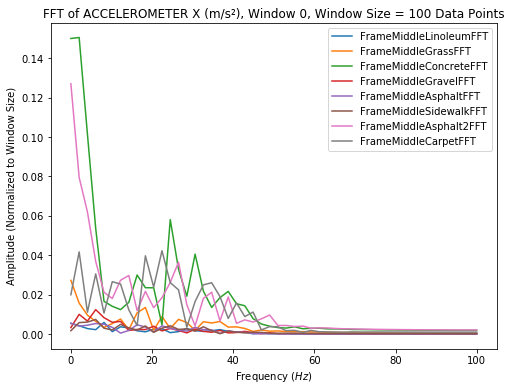

In [38]:
# Plot Z Accel of 0th window, frame only
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Frame' in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=0, transform_name='FFT')

The Butterworth cutoff frequency is pretty noticeable. Theres not an easily recognizable cutoff from the unfiltered data.

**The number of frequency bins is dependent on window sizem and it seems to affect amplitude too.**

In [ ]:
# Try Numpy conversion again
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

### Part (b) - PSD

In [ ]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], F_SAMP)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            window_psd_log[:, i] = np.log10(window_psd[:, i])
            
        # Append freq column
        freq_col = np.transpose([freq[:-1]])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [ ]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd['FrameMiddleConcretePSD'][0].shape))

In [ ]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Frame' in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=5, transform_name='PSD')

Note that at this point, data is stored like:

`Labelled Terrain Dataset -> Time Window -> 2D NumPy Array (6 cols FFT/PSD in one direction, col 7 is time, col 8 is freq)`

### Part (c) - 3D Visualization

 - FFT/PSD in 3D for each terrain
 - FFT/PSD in 3D for each direction

In [ ]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if (transform_name == 'FFT'):
        ax.set_zlim(0, 0.05)
        ax.set_zlabel('Amplitude (Normalized)')
    elif (transform_name == 'PSD'):
        ax.set_zlim(-15, 2)
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    # Change y axis to correspond with whats being plotted
    n_datasets = len(datasets_transformed)
    ax.set_ylim(0, n_datasets)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1))
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + 
                 ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
        
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        ax.plot(xs=dataset[win_num][:, -1], ys=dataset[win_num][:, dirn],
                zs=i+1, zdir='y', label=label)
    
    ax.legend()
    plt.show()

In [ ]:
# Plot 3d Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Frame' in label}
plot_transforms_3d(ffts_to_plot, win_num=0, dirn=0, transform_name='FFT')

In [ ]:
# Plot 3d Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Frame' in label}
plot_transforms_3d(psds_to_plot, win_num=0, dirn=0, transform_name='PSD')

### Part (d) - Spectograms

In [ ]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size=WINDOW_SIZE):
    # Compute spectogram directly using time series data
    # Match size of each data point bin to window size
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=F_SAMP)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    plt.show()

In [ ]:
# X Accel
plot_spectogram('FrameMiddleConcrete', 0, 200)

## Part 5 - Feature Extraction

Data storage of features:

`Labelled Terrain Dataset -> Direction -> Array with elements extracted from each time window, row = window #, col = feature`

**TODO: Convert featured datasets and feature functions to dictonaries**

In [ ]:
# Feature extraction functions

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    return num / denom

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    return num / denom

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [ ]:
'''Extract given features from everything in dataset'''
def feature_all(feat_funcs, feat_names, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = []

        for i in range(N_DATA_COL):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, N_DATA_COL+1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for func in feat_funcs:
                feats.append(function_all_windows(func))
            
            directions.append(np.transpose(np.array(feats)))

        datasets_feat.update({label: directions})
    
    return datasets_feat

In [ ]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, feat_names, dirn=0, feat_num=0):
    plt.clf()
    plt.figure(figsize=(8,6))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][:, feat_num], label=label)
        
    plt.ylabel(feat_names[feat_num])
    plt.xlabel('Window #')
    plt.title(data_columns[dirn] + ', Window Size = {} Data Points'.format(WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [ ]:
# Time domain feature function names and actual names
time_feat_names = [np.mean, np.std, l2norm, autocorr, np.amax, np.amin, rms, zcr, stats.skew, stats.kurtosis] 
time_feat_funcs = ['Mean', 'Std Dev', 'L2 Norm', 'Autocorrelation', 'Max', 'Min', 'Root Mean Squared',
                   'Zero Crossing Rate', 'Skew', 'Excess Kurtosis']
N_TIME_FEATS = len(time_feat_funcs)

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_feat_funcs, time_feat_names, datasets_windowed)

In [ ]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]][0].shape))

In [ ]:
# Plot Max of Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Frame' in label}
plot_set_features(feat_datasets_to_plot, time_feat_names, dirn=2, feat=1)

### Part (b) - Frequency Domain Features

In [ ]:
# Time domain feature function names and actual names
freq_feat_funcs = [msf, rmsf, fc, vf, rvf]
freq_feat_names = ['Mean Square Frequency', 'Root Mean Square Frequency', 'Frequency Center', 'Variance Frequency',
                   'Root Variance Frequency']
N_FREQ_FEATS = len(freq_feat_names)

# Calculate features for each window of each column of each dataset
# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_feat_funcs, freq_feat_names, datasets_psd, regular=False)

In [ ]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[0])))
print('Shape of one direction: {}'.format(datasets_feat_freq[0][0].shape))

In [ ]:
# Plot RVF of Z Accel
plot_set_features(datasets_feat_freq, freq_feat_names, dirn=2, feat=4)

Lots of very similar shapes i.e. highly correlated variables in both time and frequency. Need to implement feature selection.

**Ideally we can implement feature selection over all directions, with FFT + PSD + Time Features + Freq Features**

In [ ]:
# Verify pandas conversion
np_to_pd(datasets_feat_freq, windowed=True)[0][0].head()

## Part 5 - Feature Selection

In [ ]:
'Add labels to a dataset'
def insert_labels(datasets):
    for i, dataset in enumerate(datasets):
        for j, direction in enumerate(dataset):
            # Insert terrain labels
            labels = [dataset_labels[i] for k in range(len(direction))]
            direction.insert(0, 'Label', labels)

### Part (a) - Standardization

Standardize each feature to mean 0 and standard deviation 1. This will make PCA and classification easier.

In [ ]:
'''Normalize an already featured dataset'''
def normalize_featured_datasets(datasets, n_feats):
    for dataset in datasets:
        for direction in dataset:
            for i in range(n_feats):
                direction[:, i] = pre.scale(direction[:, i])

'''Normalize a transformed dataset'''
def normalize_transformed_datasets(datasets):
    for dataset in datasets:
        for window in dataset:
            for i in range(N_DATA_COL):
                window[:, i] = pre.scale(window[:, i]) 

In [ ]:
normalize_featured_datasets(datasets_feat_freq, N_FREQ_FEATS)
normalize_featured_datasets(datasets_feat_time, N_TIME_FEATS)
normalize_transformed_datasets(datasets_fft)
normalize_transformed_datasets(datasets_psd)

In [ ]:
# Verify that each feature has mean 0 and variance one, here for Grass X Accel time
for i in range(N_TIME_FEATS):
    feat = datasets_feat_time[0][0][:, i]
    print('Mean = {}, Var = {}'.format(np.mean(feat), np.var(feat)))

In [ ]:
# Plot normalized features
plot_set_features(datasets_feat_time, time_feat_names, dirn=2, feat=3)

In [ ]:
# Plot normalized fft
plot_set_transforms(datasets_fft, 2, 3, 'FFT')

### Part (b) - mRMR

Necessary because of the number of different features/transforms in each direction.

Try to find which features are most relevant, from all directions.

In [ ]:
datasets_feat_freq = np_to_pd(datasets_feat_freq, windowed=True)

In [ ]:
# Insert terrain labels
insert_labels(datasets_feat_freq)

In [ ]:
datasets_feat_freq[0][0].head()

In [ ]:
# Need to convert everything to a single pandas dataset
def to_single_dataframe(datasets, feat_names):
    # Create the columns of the array
    
    columns = ['Label']
    for j in range(N_DATA_COL):
        for name in feat_names:
            columns.append(dataset_columns[j] + ' ' + name)
    dataframe = pd.DataFrame(columns=columns, index=[])
    
    for i, dataset in enumerate(datasets):
        set_dataframe = pd.DataFrame(columns)
        
        for j, direction in enumerate(dataset[1:]):
            # Direction labelled columns
            direction_columns = ['Label']
            for name in feat_names:
                direction_columns.append(dataset_columns[j] + ' ' + name)
            
            # Data directions into a single dataframe
            direction.columns = direction_columns
            set_dataframe = set_dataframe.append(direction)
            
        # Combine datasets into a single dataframe
        dataframe.append(dataset)
    
    return dataframe

In [ ]:
freq_feats = to_single_dataframe(datasets_feat_freq, freq_feat_names)
freq_feats.head()

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction` - Linear acceleration or gyroscope in $x,y$ or $z$